Using device: cpu
Feature shape: (10000, 128)
Cluster counts: [2981 7019]


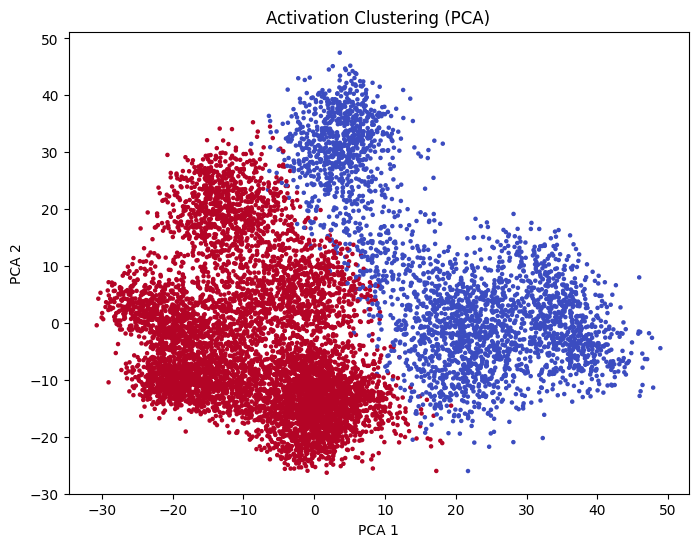

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------------
# Load Backdoor Model
# --------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x, return_features=False):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 64 * 7 * 7)
        features = torch.relu(self.fc1(x))
        out = self.fc2(features)
        if return_features:
            return features
        return out

model = SimpleCNN().to(device)
model.load_state_dict(torch.load("../data/backdoor_cnn.pth", map_location=device))
model.eval()

# --------------------------
# Load Clean Test Data
# --------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset = datasets.MNIST("../data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# --------------------------
# Extract Last-Layer Activations
# --------------------------
features_list = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        feats = model(imgs, return_features=True)
        features_list.append(feats.cpu().numpy())

features = np.concatenate(features_list, axis=0)
print("Feature shape:", features.shape)

# --------------------------
# KMeans Clustering into 2 Groups
# --------------------------
kmeans = KMeans(n_clusters=2, random_state=0).fit(features)
clusters = kmeans.labels_

print("Cluster counts:", np.bincount(clusters))

# --------------------------
# PCA for Visualization
# --------------------------
pca = PCA(n_components=2)
reduced = pca.fit_transform(features)

plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], c=clusters, cmap="coolwarm", s=5)
plt.title("Activation Clustering (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()
